#🚀 Custom Transformer Components

## Multi-Head Attention Variants

---

## 1. Symbols & Definitions

* **`d_model`** → embedding size of the model (here 256).

* **`num_heads`** → number of **query heads** (here 8).

* **`d_head`** → dimension of each query head:

  $$
  d_{head} = \frac{d_{model}}{num\_heads}
  $$

  → In your case: $256 / 8 = 32$.

* **`num_kv_heads`** → number of **key/value heads**.

  * Vanilla MHA: $num\_kv\_heads = num\_heads$.
  * GQA: $num\_kv\_heads < num\_heads$.
  * MQA: $num\_kv\_heads = 1$.

* **`d_kv`** → the **dimension of all K/V projections combined**.

  $$
  d_{kv} = d_{head} \times num\_kv\_heads
  $$

---

## 2. What each part means

* **`d_head` (32 in your case):**
  The “width” of a single attention head. Each query head looks at tokens through a subspace of size 32.

* **`num_kv_heads` (e.g. 1, 2, or 8):**
  How many *distinct* sets of K/V vectors are learned.

  * If 8 → every query head has its own K/V (MHA).
  * If 2 → groups of query heads share K/V (GQA).
  * If 1 → all queries share one K/V (MQA).

* **Multiplication `d_head × num_kv_heads`:**
  This gives the **total dimensionality of the projected K and V matrices**.

  * That’s why `w_k` and `w_v` have shapes `[d_kv, d_model]`.

---

## 3. Intuition of the multiplication

Think of it like this:

* Each KV head = a "view" into the sequence, of size `d_head`.
* If you have multiple KV heads, you stack them side by side.
* So the total space you need to project into is just:

  $$
  \text{total KV dimension} = d_{head} \times num\_kv\_heads
  $$

---

## 4. Concrete Examples (your config)

* **MHA (8 KV heads):**
  $d_{kv} = 32 \times 8 = 256$
  → K/V projection: `[256, 256]`

* **GQA (2 KV heads):**
  $d_{kv} = 32 \times 2 = 64$
  → K/V projection: `[64, 256]`

* **MQA (1 KV head):**
  $d_{kv} = 32 \times 1 = 32$
  → K/V projection: `[32, 256]`

---

✅ **Summary**:

* `d_head` → how wide each head is.
* `num_kv_heads` → how many *independent* K/V sets you maintain.
* `d_head × num_kv_heads` → total dimensionality of the K/V projection layer, i.e. how many numbers represent your keys/values per token.

---



In [6]:
def create_text_example():
    """Create a simple tokenized text example for testing"""
    # Simple vocabulary mapping for demonstration
    vocab = {
        '<pad>': 0, '<sos>': 1, '<eos>': 2,
        'the': 3, 'cat': 4, 'sat': 5, 'on': 6, 'mat': 7,
        'dog': 8, 'ran': 9, 'fast': 10, 'bird': 11, 'flew': 12, 'high': 13
    }

    # Example sentences (tokenized)
    sentences = [
        "the cat sat on the mat",
        "the dog ran fast",
        "the bird flew high"
    ]

    # Convert to token IDs
    tokenized_sentences = []
    for sentence in sentences:
        tokens = [vocab['<sos>']]  # Start token
        tokens.extend([vocab.get(word, 0) for word in sentence.split()])
        tokens.append(vocab['<eos>'])  # End token
        tokenized_sentences.append(tokens)

    return tokenized_sentences, vocab


def pad_sequences(sequences, max_len=None, pad_value=0):
    """Pad sequences to the same length"""
    if max_len is None:
        max_len = max(len(seq) for seq in sequences)

    padded = []
    for seq in sequences:
        if len(seq) < max_len:
            padded.append(seq + [pad_value] * (max_len - len(seq)))
        else:
            padded.append(seq[:max_len])

    return padded

In [7]:
tokenized_sentences, vocab = create_text_example()
tokenized_sentences

[[1, 3, 4, 5, 6, 3, 7, 2], [1, 3, 8, 9, 10, 2], [1, 3, 11, 12, 13, 2]]

In [9]:
test_padded_sequences = pad_sequences(tokenized_sentences)
test_padded_sequences

[[1, 3, 4, 5, 6, 3, 7, 2],
 [1, 3, 8, 9, 10, 2, 0, 0],
 [1, 3, 11, 12, 13, 2, 0, 0]]

In [16]:
import torch

test_input_ids = torch.tensor(test_padded_sequences)
test_input_ids.shape,test_input_ids

(torch.Size([3, 8]),
 tensor([[ 1,  3,  4,  5,  6,  3,  7,  2],
         [ 1,  3,  8,  9, 10,  2,  0,  0],
         [ 1,  3, 11, 12, 13,  2,  0,  0]]))

### Multi-Query Attention (MQA) - Memory efficient

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

# Multi-Query Attention (MQA) - Memory efficient
class MultiQueryAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.w_q = nn.Linear(d_model, d_model)  # Multiple query heads
        self.w_k = nn.Linear(d_model, self.d_k)  # Single key head
        self.w_v = nn.Linear(d_model, self.d_k)  # Single value head
        self.w_o = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        B, T, C = x.shape

        # Q: [B, T, d_model] -> [B, num_heads, T, d_k]
        q = self.w_q(x).view(B, T, self.num_heads, self.d_k).transpose(1, 2)
        # K, V: [B, T, C] -> [B, 1, T, d_k] -> broadcast to [B, num_heads, T, d_k]
        k = self.w_k(x).view(B, T, 1, self.d_k).transpose(1, 2).expand(-1, self.num_heads, -1, -1)
        v = self.w_v(x).view(B, T, 1, self.d_k).transpose(1, 2).expand(-1, self.num_heads, -1, -1)

        # Scaled dot-product attention
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            scores.masked_fill_(mask == 0, -1e9)

        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)

        out = torch.matmul(attn_weights, v)  # [B, num_heads, T, d_k]
        out = out.transpose(1, 2).contiguous().view(B, T, C)
        return self.w_o(out)



| Method  | num\_heads | num\_kv\_heads | Total Params |
| ------- | ---------- | -------------- | ------------ |
| **MHA** | 8          | 8              | **262,400**  |
| **GQA** | 8          | 2              | **164,480**  |
| **MQA** | 8          | 1              | **148,032**  |

**MHA (full)**: Heaviest — every query head has its own KV projections.

**GQA (middle ground)**: Balance — queries are many, but KVs are grouped. (LLaMA-2/3 style)

**MQA (extreme case)**: Lightest — one shared KV for all query heads (PaLM, Gemini, Whisper use this).

    w_k or w_v [d_kv, d_model] = [32, 256]

Because you’re using MQA with num_heads=8 but only num_kv_heads=1, the keys/values don’t need a full 256-d projection. Instead:

    Each KV head gets dimension: d_model/num_heads = 265/8 = 32
    With 1 KV heads (num_kv_heads=1) = 32 * 2 = 32



In [21]:

def test_multi_query_attention():
    """Test the MultiQueryAttention module with text examples"""
    print("Testing Multi-Query Attention with Text Examples")
    print("=" * 60)

    # Set random seed for reproducibility
    torch.manual_seed(42)

    # Create text examples
    tokenized_sentences, vocab = create_text_example()
    print("Original sentences:")
    sentences = ["the cat sat on the mat", "the dog ran fast", "the bird flew high"]
    for i, sentence in enumerate(sentences):
        print(f"  {i+1}. '{sentence}' -> {tokenized_sentences[i]}")

    # Pad sequences
    max_seq_len = 8
    padded_sequences = pad_sequences(tokenized_sentences, max_seq_len)
    input_ids = torch.tensor(padded_sequences)

    print(f"\nPadded input tensor shape: {input_ids.shape}")
    print("Padded sequences:")
    for i, seq in enumerate(padded_sequences):
        print(f"  Sequence {i+1}: {seq}")

    # Model configuration
    d_model = 256
    num_heads = 8
    vocab_size = len(vocab)
    batch_size, seq_length = input_ids.shape

    print(f"\nModel Configuration:")
    print(f"  d_model: {d_model}")
    print(f"  num_heads: {num_heads}")
    print(f"  vocab_size: {vocab_size}")
    print(f"  sequence_length: {seq_length}")

    # Create embedding layer and MQA
    embedding = nn.Embedding(vocab_size, d_model, padding_idx=0)
    mqa = MultiQueryAttention(d_model, num_heads, dropout=0.1)

    # Convert tokens to embeddings
    x = embedding(input_ids)  # [batch_size, seq_length, d_model]
    print(f"\nEmbedding output shape [batch_size, seq_length, d_model]: {x.shape}")

    # Create attention mask (ignore padding tokens)
    attention_mask = (input_ids != 0).float()
    causal_mask = attention_mask.unsqueeze(1).unsqueeze(2)
    causal_mask = causal_mask.expand(-1, num_heads, seq_length, -1)

    print(f"\nAttention mask shape [batch_size, seq_length]: {attention_mask.shape}")
    print(f"\nAttention mask shape [batch_size, seq_length, seq_length,seq_length]: {causal_mask.shape}")
    print("Attention mask for first sequence (first head):")
    print(causal_mask[0, 0].int())

    # Forward pass through GQA
    print("\n" + "-" * 40)
    print("Running MQA Forward Pass...")
    mqa.eval()
    with torch.no_grad():
        output = mqa(x, mask=causal_mask)

    print(f"\nGQA output shape: {output.shape}")
    print("Output statistics:")
    print(f"  Mean: {output.mean():.4f}")
    print(f"  Std: {output.std():.4f}")
    print(f"  Min: {output.min():.4f}")
    print(f"  Max: {output.max():.4f}")

    # Show parameter breakdown
    print(f"\nModel Parameter Analysis:")
    total_params = sum(p.numel() for p in mqa.parameters())
    print(f"  Total GQA parameters: {total_params:,}")

    print("\n  Parameter breakdown:")
    for name, param in mqa.named_parameters():
        print(f"    {name}: {param.shape} -> {param.numel():,} parameters")

    print("\nTest completed successfully!")

In [22]:
test_multi_query_attention()

Testing Multi-Query Attention with Text Examples
Original sentences:
  1. 'the cat sat on the mat' -> [1, 3, 4, 5, 6, 3, 7, 2]
  2. 'the dog ran fast' -> [1, 3, 8, 9, 10, 2]
  3. 'the bird flew high' -> [1, 3, 11, 12, 13, 2]

Padded input tensor shape: torch.Size([3, 8])
Padded sequences:
  Sequence 1: [1, 3, 4, 5, 6, 3, 7, 2]
  Sequence 2: [1, 3, 8, 9, 10, 2, 0, 0]
  Sequence 3: [1, 3, 11, 12, 13, 2, 0, 0]

Model Configuration:
  d_model: 256
  num_heads: 8
  vocab_size: 14
  sequence_length: 8

Embedding output shape [batch_size, seq_length, d_model]: torch.Size([3, 8, 256])

Attention mask shape [batch_size, seq_length]: torch.Size([3, 8])

Attention mask shape [batch_size, seq_length, seq_length,seq_length]: torch.Size([3, 8, 8, 8])
Attention mask for first sequence (first head):
tensor([[1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1],
 

### Grouped Query Attention (GQA) - Balanced approach

In [12]:
# Grouped Query Attention (GQA) - Balanced approach
class GroupedQueryAttention(nn.Module):
    def __init__(self, d_model, num_heads, num_kv_heads, dropout=0.1):
        super().__init__()
        assert num_heads % num_kv_heads == 0

        self.d_model = d_model
        self.num_heads = num_heads
        self.num_kv_heads = num_kv_heads
        self.d_k = d_model // num_heads
        self.groups = num_heads // num_kv_heads

        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, num_kv_heads * self.d_k)
        self.w_v = nn.Linear(d_model, num_kv_heads * self.d_k)
        self.w_o = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        B, T, C = x.shape

        # Q: [B, T, d_model] -> [B, num_heads, T, d_k]
        q = self.w_q(x).view(B, T, self.num_heads, self.d_k).transpose(1, 2)
        # K, V: [B, T, C] -> [B, num_kv_heads, T, d_k]
        k = self.w_k(x).view(B, T, self.num_kv_heads, self.d_k).transpose(1, 2)
        v = self.w_v(x).view(B, T, self.num_kv_heads, self.d_k).transpose(1, 2)

        # Repeat K, V for each group
        k = k.repeat_interleave(self.groups, dim=1)  # [B, num_heads, T, d_k]
        v = v.repeat_interleave(self.groups, dim=1)

        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            scores.masked_fill_(mask == 0, -1e9)

        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)

        out = torch.matmul(attn_weights, v)
        out = out.transpose(1, 2).contiguous().view(B, T, C)
        return self.w_o(out)



    w_q [d_model, d_model] = [256, 256]
This projects the input embedding of size 256 into queries of the same size (since you have 8 query heads).

    w_k or w_v [d_kv, d_model] = [64, 256]

Because you’re using GQA with num_heads=8 but only num_kv_heads=2, the keys/values don’t need a full 256-d projection. Instead:

    Each KV head gets dimension: d_model/num_heads = 265/8 = 32
    With 2 KV heads (num_kv_heads=2) = 32 * 2 = 64

After attention scores are applied, you project the concatenated heads back to the model dimension.

    w_o [d_model, d_model] = [256, 256]

**Why queries are bigger (256-d) but keys/values are smaller (64-d)?**

  → Because in Grouped-Query Attention (GQA), you have more query heads (8) than key/value heads (2). This reduces memory/computation since multiple query heads can share the same smaller key/value projections.

In [19]:
def test_group_query_attention():
    """Test the GroupQueryAttention module with text examples"""
    print("Testing Group-Query Attention with Text Examples")
    print("=" * 60)

    # Set random seed for reproducibility
    torch.manual_seed(42)

    # Create text examples
    tokenized_sentences, vocab = create_text_example()
    print("Original sentences:")
    sentences = ["the cat sat on the mat", "the dog ran fast", "the bird flew high"]
    for i, sentence in enumerate(sentences):
        print(f"  {i+1}. '{sentence}' -> {tokenized_sentences[i]}")

    # Pad sequences
    max_seq_len = 8
    padded_sequences = pad_sequences(tokenized_sentences, max_seq_len)
    input_ids = torch.tensor(padded_sequences)

    print(f"\nPadded input tensor shape: {input_ids.shape}")
    print("Padded sequences:")
    for i, seq in enumerate(padded_sequences):
        print(f"  Sequence {i+1}: {seq}")

    # Model configuration
    d_model = 256
    num_heads = 8
    num_kv_heads = 2   # Set for GQA (for example, 2 kv heads for 8 query heads)
    vocab_size = len(vocab)
    batch_size, seq_length = input_ids.shape

    print(f"\nModel Configuration:")
    print(f"  d_model: {d_model}")
    print(f"  num_heads: {num_heads}")
    print(f"  num_kv_heads: {num_kv_heads}")
    print(f"  vocab_size: {vocab_size}")
    print(f"  sequence_length: {seq_length}")

    # Create embedding layer and GroupedQueryAttention
    embedding = nn.Embedding(vocab_size, d_model, padding_idx=0)
    gqa = GroupedQueryAttention(d_model, num_heads, num_kv_heads, dropout=0.1)

    # Convert tokens to embeddings
    x = embedding(input_ids)  # [batch_size, seq_length, d_model]
    print(f"\nEmbedding output shape: {x.shape}")

    # Create attention mask (ignore padding tokens)
    attention_mask = (input_ids != 0).float()
    causal_mask = attention_mask.unsqueeze(1).unsqueeze(2)
    causal_mask = causal_mask.expand(-1, num_heads, seq_length, -1)

    print(f"\nAttention mask shape [batch_size, seq_length]: {attention_mask.shape}")
    print(f"\nAttention mask shape [batch_size, seq_length, seq_length,seq_length]: {causal_mask.shape}")
    print("Attention mask for first sequence (first head):")
    print(causal_mask[0, 0].int())

    # Forward pass through GQA
    print("\n" + "-" * 40)
    print("Running GQA Forward Pass...")
    gqa.eval()
    with torch.no_grad():
        output = gqa(x, mask=causal_mask)

    print(f"\nGQA output shape: {output.shape}")
    print("Output statistics:")
    print(f"  Mean: {output.mean():.4f}")
    print(f"  Std: {output.std():.4f}")
    print(f"  Min: {output.min():.4f}")
    print(f"  Max: {output.max():.4f}")

    # Show parameter breakdown
    print(f"\nModel Parameter Analysis:")
    total_params = sum(p.numel() for p in gqa.parameters())
    print(f"  Total GQA parameters: {total_params:,}")

    print("\n  Parameter breakdown:")
    for name, param in gqa.named_parameters():
        print(f"    {name}: {param.shape} -> {param.numel():,} parameters")

    print("\nTest completed successfully!")

In [20]:
test_group_query_attention()

Testing Group-Query Attention with Text Examples
Original sentences:
  1. 'the cat sat on the mat' -> [1, 3, 4, 5, 6, 3, 7, 2]
  2. 'the dog ran fast' -> [1, 3, 8, 9, 10, 2]
  3. 'the bird flew high' -> [1, 3, 11, 12, 13, 2]

Padded input tensor shape: torch.Size([3, 8])
Padded sequences:
  Sequence 1: [1, 3, 4, 5, 6, 3, 7, 2]
  Sequence 2: [1, 3, 8, 9, 10, 2, 0, 0]
  Sequence 3: [1, 3, 11, 12, 13, 2, 0, 0]

Model Configuration:
  d_model: 256
  num_heads: 8
  num_kv_heads: 2
  vocab_size: 14
  sequence_length: 8

Embedding output shape: torch.Size([3, 8, 256])

Attention mask shape [batch_size, seq_length, seq_length]: torch.Size([3, 8])

Attention mask shape [batch_size, seq_length, seq_length,seq_length]: torch.Size([3, 8, 8, 8])
Attention mask for first sequence (first head):
tensor([[1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1],
     

### FlexAttention - PyTorch 2.5+ with custom score modifiers

In [23]:
# FlexAttention - PyTorch 2.5+ with custom score modifiers

import torch

def causal_mask(score, batch, head, q_idx, kv_idx):
    return torch.where(q_idx >= kv_idx, score, float('-inf'))

def sliding_window_mask(window_size):
    def mask_fn(score, batch, head, q_idx, kv_idx):
        return torch.where(
            torch.abs(q_idx - kv_idx) <= window_size,
            score, float('-inf')
        )
    return mask_fn


def attention_bias_mask(bias_value=0.1):
    """Add a small bias to attention scores"""
    def mask_fn(score, batch, head, q_idx, kv_idx):
        return score + bias_value
    return mask_fn


def position_dependent_mask(decay_factor=0.1):
    """Apply position-dependent decay to attention scores"""
    def mask_fn(score, batch, head, q_idx, kv_idx):
        distance = torch.abs(q_idx - kv_idx).float()
        decay = torch.exp(-decay_factor * distance)
        return score * decay
    return mask_fn


class FlexAttentionWrapper(nn.Module):
    """Wrapper for FlexAttention with different score modifiers"""
    def __init__(self, d_model, num_heads, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_o = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, score_mod=None):
        B, T, C = x.shape

        # Generate Q, K, V
        q = self.w_q(x).view(B, T, self.num_heads, self.d_k).transpose(1, 2)
        k = self.w_k(x).view(B, T, self.num_heads, self.d_k).transpose(1, 2)
        v = self.w_v(x).view(B, T, self.num_heads, self.d_k).transpose(1, 2)

        # Use FlexAttention if available, otherwise fallback to standard attention
        try:
            from torch.nn.attention.flex_attention import flex_attention
            # FlexAttention expects [B, H, T, D] format
            if score_mod is not None:
                out = flex_attention(q, k, v, score_mod=score_mod)
            else:
                out = flex_attention(q, k, v)
        except ImportError:
            print("FlexAttention not available, using standard attention fallback")
            # Fallback to standard attention
            scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.d_k)

            # Apply score modifier manually if provided
            if score_mod is not None:
                print("Warning: score_mod ignored in fallback mode")

            attn_weights = F.softmax(scores, dim=-1)
            attn_weights = self.dropout(attn_weights)
            out = torch.matmul(attn_weights, v)

        # Reshape output
        out = out.transpose(1, 2).contiguous().view(B, T, C)
        return self.w_o(out)

# Usage with FlexAttention (PyTorch 2.5+)
# from torch.nn.attention.flex_attention import flex_attention
# output = flex_attention(query, key, value, score_mod=causal_mask)

In [30]:
def test_flex_attention():
    """Test the FlexAttention wrapper with different score modifiers"""
    print("Testing FlexAttention with Text Examples")
    print("=" * 60)

    # Set random seed for reproducibility
    torch.manual_seed(42)

    # Create text examples
    tokenized_sentences, vocab = create_text_example()
    print("Original sentences:")
    sentences = [
        "the cat sat on the mat",
        "the dog ran fast",
        "the bird flew high",
        "the quick brown fox jumps"
    ]
    # for i, sentence in enumerate(sentences):
    #     print(f"  {i+1}. '{sentence}' -> {tokenized_sentences[i]}")

    # Pad sequences
    max_seq_len = 10
    padded_sequences = pad_sequences(tokenized_sentences, max_seq_len)
    input_ids = torch.tensor(padded_sequences)

    print(f"\nPadded input tensor shape: {input_ids.shape}")
    print("Padded sequences:")
    for i, seq in enumerate(padded_sequences):
        print(f"  Sequence {i+1}: {seq}")

    # Model configuration
    d_model = 256
    num_heads = 8
    vocab_size = len(vocab)
    batch_size, seq_length = input_ids.shape

    print(f"\nModel Configuration:")
    print(f"  d_model: {d_model}")
    print(f"  num_heads: {num_heads}")
    print(f"  vocab_size: {vocab_size}")
    print(f"  sequence_length: {seq_length}")

    # Create embedding layer and FlexAttention
    embedding = nn.Embedding(vocab_size, d_model, padding_idx=0)
    flex_attn = FlexAttentionWrapper(d_model, num_heads, dropout=0.1)

    # Convert tokens to embeddings
    x = embedding(input_ids)  # [batch_size, seq_length, d_model]
    print(f"\nEmbedding output shape: {x.shape}")

    # Test different score modifiers
    score_modifiers = {
        "No modifier": None,
        "Causal mask": causal_mask,
        "Sliding window (size=3)": sliding_window_mask(3),
        "Sliding window (size=5)": sliding_window_mask(5),
        "Attention bias": attention_bias_mask(0.1),
        "Position decay": position_dependent_mask(0.2)
    }

    print("\n" + "-" * 50)
    print("Testing Different Score Modifiers")
    print("-" * 50)

    flex_attn.eval()
    results = {}

    for name, score_mod in score_modifiers.items():
        print(f"\nTesting: {name}")
        print("-" * 30)

        with torch.no_grad():
            try:
                output = flex_attn(x, score_mod=score_mod)
                results[name] = output

                print(f"  Output shape: {output.shape}")
                print(f"  Output statistics:")
                print(f"    Mean: {output.mean():.4f}")
                print(f"    Std: {output.std():.4f}")
                print(f"    Min: {output.min():.4f}")
                print(f"    Max: {output.max():.4f}")

            except Exception as e:
                print(f"  Error: {e}")
                results[name] = None

    # Compare different score modifiers
    print("\n" + "-" * 50)
    print("Comparing Score Modifiers")
    print("-" * 50)

    base_output = results.get("No modifier")
    if base_output is not None:
        for name, output in results.items():
            if output is not None and name != "No modifier":
                diff = torch.abs(output - base_output).mean()
                print(f"{name:25} vs No modifier: Avg diff = {diff:.6f}")

    # Parameter analysis
    print(f"\nModel Parameter Analysis:")
    total_params = sum(p.numel() for p in flex_attn.parameters())
    print(f"  Total FlexAttention parameters: {total_params:,}")

    print("\n  Parameter breakdown:")
    for name, param in flex_attn.named_parameters():
        print(f"    {name}: {param.shape} -> {param.numel():,} parameters")

    print("\n" + "=" * 60)
    print("FlexAttention test completed!")

    return flex_attn, results, input_ids, vocab


def test_score_modifier_behaviors():
    """Test specific behaviors of different score modifiers"""
    print("\n" + "=" * 60)
    print("Testing Score Modifier Behaviors")
    print("=" * 60)

    # Create simple test data
    seq_len = 6
    batch_size = 1

    # Simulate score matrix for visualization
    print("\nScore Modifier Behavior Analysis:")
    print("(Simulating attention patterns)")

    # Test causal mask
    print("\n1. Causal Mask:")
    print("   Only allows attention to previous positions")
    for q_idx in range(seq_len):
        mask_pattern = []
        for kv_idx in range(seq_len):
            if q_idx >= kv_idx:
                mask_pattern.append("✓")
            else:
                mask_pattern.append("✗")
        print(f"   Position {q_idx}: {' '.join(mask_pattern)}")

    # Test sliding window
    window_size = 2
    print(f"\n2. Sliding Window (size={window_size}):")
    print("   Only allows attention within window")
    for q_idx in range(seq_len):
        mask_pattern = []
        for kv_idx in range(seq_len):
            if abs(q_idx - kv_idx) <= window_size:
                mask_pattern.append("✓")
            else:
                mask_pattern.append("✗")
        print(f"   Position {q_idx}: {' '.join(mask_pattern)}")

    print("\n3. Position Decay:")
    print("   Attention strength decreases with distance")
    decay_factor = 0.3
    for q_idx in [0, 2, 4]:
        decay_values = []
        for kv_idx in range(seq_len):
            distance = abs(q_idx - kv_idx)
            decay = math.exp(-decay_factor * distance)
            decay_values.append(f"{decay:.2f}")
        print(f"   From pos {q_idx}: {' '.join(decay_values)}")


In [25]:
def demonstrate_flex_attention_features():
    """Demonstrate key features of FlexAttention"""
    print("\n" + "=" * 60)
    print("FlexAttention Key Features")
    print("=" * 60)

    features = [
        "✓ Custom score modification functions",
        "✓ Efficient computation with PyTorch 2.5+",
        "✓ Support for causal masking",
        "✓ Sliding window attention patterns",
        "✓ Position-dependent attention weighting",
        "✓ Flexible attention bias injection",
        "✓ Memory-efficient implementation",
        "✓ Backward compatibility fallback"
    ]

    print("\nSupported Features:")
    for feature in features:
        print(f"  {feature}")

    print("\nUse Cases:")
    use_cases = [
        "• Language modeling with causal attention",
        "• Local attention for long sequences",
        "• Position-biased attention mechanisms",
        "• Custom attention patterns for specific tasks",
        "• Efficient transformer variants"
    ]

    for use_case in use_cases:
        print(f"  {use_case}")


In [31]:
# Run main test
flex_model, results, input_ids, vocab = test_flex_attention()



Testing FlexAttention with Text Examples
Original sentences:

Padded input tensor shape: torch.Size([3, 10])
Padded sequences:
  Sequence 1: [1, 3, 4, 5, 6, 3, 7, 2, 0, 0]
  Sequence 2: [1, 3, 8, 9, 10, 2, 0, 0, 0, 0]
  Sequence 3: [1, 3, 11, 12, 13, 2, 0, 0, 0, 0]

Model Configuration:
  d_model: 256
  num_heads: 8
  vocab_size: 14
  sequence_length: 10

Embedding output shape: torch.Size([3, 10, 256])

--------------------------------------------------
Testing Different Score Modifiers
--------------------------------------------------

Testing: No modifier
------------------------------
  Output shape: torch.Size([3, 10, 256])
  Output statistics:
    Mean: 0.0013
    Std: 0.0988
    Min: -0.3647
    Max: 0.3408

Testing: Causal mask
------------------------------
  Output shape: torch.Size([3, 10, 256])
  Output statistics:
    Mean: -0.0022
    Std: 0.1797
    Min: -0.6847
    Max: 0.8259

Testing: Sliding window (size=3)
------------------------------
  Output shape: torch.Size([

In [37]:
results.keys(),input_ids.shape


(dict_keys(['No modifier', 'Causal mask', 'Sliding window (size=3)', 'Sliding window (size=5)', 'Attention bias', 'Position decay']),
 torch.Size([3, 10]))

In [38]:
flex_model

FlexAttentionWrapper(
  (w_q): Linear(in_features=256, out_features=256, bias=True)
  (w_k): Linear(in_features=256, out_features=256, bias=True)
  (w_v): Linear(in_features=256, out_features=256, bias=True)
  (w_o): Linear(in_features=256, out_features=256, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [28]:
# Run additional analyses
test_score_modifier_behaviors()



Testing Score Modifier Behaviors

Score Modifier Behavior Analysis:
(Simulating attention patterns)

1. Causal Mask:
   Only allows attention to previous positions
   Position 0: ✓ ✗ ✗ ✗ ✗ ✗
   Position 1: ✓ ✓ ✗ ✗ ✗ ✗
   Position 2: ✓ ✓ ✓ ✗ ✗ ✗
   Position 3: ✓ ✓ ✓ ✓ ✗ ✗
   Position 4: ✓ ✓ ✓ ✓ ✓ ✗
   Position 5: ✓ ✓ ✓ ✓ ✓ ✓

2. Sliding Window (size=2):
   Only allows attention within window
   Position 0: ✓ ✓ ✓ ✗ ✗ ✗
   Position 1: ✓ ✓ ✓ ✓ ✗ ✗
   Position 2: ✓ ✓ ✓ ✓ ✓ ✗
   Position 3: ✗ ✓ ✓ ✓ ✓ ✓
   Position 4: ✗ ✗ ✓ ✓ ✓ ✓
   Position 5: ✗ ✗ ✗ ✓ ✓ ✓

3. Position Decay:
   Attention strength decreases with distance
   From pos 0: 1.00 0.74 0.55 0.41 0.30 0.22
   From pos 2: 0.55 0.74 1.00 0.74 0.55 0.41
   From pos 4: 0.30 0.41 0.55 0.74 1.00 0.74


In [29]:
demonstrate_flex_attention_features()


FlexAttention Key Features

Supported Features:
  ✓ Custom score modification functions
  ✓ Efficient computation with PyTorch 2.5+
  ✓ Support for causal masking
  ✓ Sliding window attention patterns
  ✓ Position-dependent attention weighting
  ✓ Flexible attention bias injection
  ✓ Memory-efficient implementation
  ✓ Backward compatibility fallback

Use Cases:
  • Language modeling with causal attention
  • Local attention for long sequences
  • Position-biased attention mechanisms
  • Custom attention patterns for specific tasks
  • Efficient transformer variants


# Advanced Feed-Forward Networks

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

# SwiGLU Activation (used in LLaMA, PaLM)
class SwiGLUFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.w1 = nn.Linear(d_model, d_ff, bias=False)  # Gate
        self.w2 = nn.Linear(d_ff, d_model, bias=False)   # Down projection
        self.w3 = nn.Linear(d_model, d_ff, bias=False)   # Up projection
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        gate = F.silu(self.w1(x))  # SiLU activation
        up = self.w3(x)
        return self.w2(self.dropout(gate * up))

# Mixture of Experts (MoE) Layer
class MoELayer(nn.Module):
    def __init__(self, d_model, d_ff, num_experts, top_k=2, dropout=0.1):
        super().__init__()
        self.num_experts = num_experts
        self.top_k = top_k
        self.d_model = d_model

        # Router network
        self.gate = nn.Linear(d_model, num_experts, bias=False)

        # Expert networks (batched for efficiency)
        self.experts_w1 = nn.Parameter(torch.randn(num_experts, d_model, d_ff))
        self.experts_w2 = nn.Parameter(torch.randn(num_experts, d_ff, d_model))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape

        # Compute routing weights
        router_logits = self.gate(x)  # [B, T, num_experts]
        routing_weights = F.softmax(router_logits, dim=-1)

        # Select top-k experts
        top_k_weights, top_k_indices = torch.topk(routing_weights, self.top_k, dim=-1)
        top_k_weights = F.softmax(top_k_weights, dim=-1)

        # Reshape for batched expert computation
        x_expanded = x.unsqueeze(2).expand(B, T, self.top_k, C)  # [B, T, top_k, C]

        # Gather expert weights
        expert_w1 = self.experts_w1[top_k_indices]  # [B, T, top_k, C, d_ff]
        expert_w2 = self.experts_w2[top_k_indices]  # [B, T, top_k, d_ff, C]

        # Apply experts
        hidden = torch.matmul(x_expanded.unsqueeze(-2), expert_w1).squeeze(-2)  # [B, T, top_k, d_ff]
        hidden = F.gelu(hidden)
        hidden = self.dropout(hidden)
        outputs = torch.matmul(hidden.unsqueeze(-2), expert_w2).squeeze(-2)  # [B, T, top_k, C]

        # Weighted combination
        final_output = torch.sum(outputs * top_k_weights.unsqueeze(-1), dim=2)  # [B, T, C]

        return final_output, routing_weights



In [51]:
import matplotlib.pyplot as plt

def test_swiglu_and_moe():
    """
    Test SwiGLUFeedForward and MoELayer using a precomputed input_ids tensor.
    Expects input_ids: LongTensor of shape [B, T].
    """
    # Set random seed for reproducibility
    torch.manual_seed(42)

    # Create text examples
    tokenized_sentences, vocab = create_text_example()
    print("Original sentences:")
    sentences = [
        "the cat sat on the mat",
        "the dog ran fast",
        "the bird flew high",
        "the quick brown fox jumps"
    ]
    # for i, sentence in enumerate(sentences):
    #     print(f"  {i+1}. '{sentence}' -> {tokenized_sentences[i]}")

    # Pad sequences
    max_seq_len = 10
    padded_sequences = pad_sequences(tokenized_sentences, max_seq_len)
    input_ids = torch.tensor(padded_sequences)

    print(f"\nPadded input tensor shape: {input_ids.shape}")
    print("Padded sequences:")
    for i, seq in enumerate(padded_sequences):
        print(f"  Sequence {i+1}: {seq}")

    # Model configuration (using GQA config)
    d_model = 256
    num_heads = 8
    d_head = d_model//num_heads # dimension of each KV heads
    num_kv_heads=2 # use 1 for MQA
    d_kv = d_head * num_kv_heads
    n_experts = 8
    vocab_size = len(vocab)
    batch_size, seq_length = input_ids.shape

    print(f"\nModel Configuration:")
    print(f"  d_model: {d_model}")
    print(f"  num_heads: {num_heads}")
    print(f"  dimension of each KV heads (d_head): {d_head}")
    print(f"  number of KV heads (num_kv_heads): {num_kv_heads}")
    print(f"  dimension of all K/V projections combined (d_kv): {d_kv}")
    print(f"  number of experts (n_experts): {n_experts}")
    print(f"  vocab_size: {vocab_size}")
    print(f"  sequence_length: {seq_length}")

    # Embedding layer to convert IDs → embeddings
    # Create embedding layer
    embedding = nn.Embedding(vocab_size, d_head, padding_idx=0)

    # Convert tokens to embeddings
    x = embedding(input_ids)  # [batch_size, seq_length, d_head]
    print(f"\nEmbedding output shape [batch_size, seq_length, d_head]: {x.shape}")

    # SwiGLU Feed-Forward
    ff = SwiGLUFeedForward(d_model=d_head, d_ff=d_kv)
    out_ff = ff(x)
    print(f"SwiGLUFeedForward output shape: {out_ff.shape}")

    # MoE Layer
    moe = MoELayer(d_model=d_head, d_ff=d_kv, num_experts=n_experts, top_k=2)
    out_moe, routing_weights = moe(x)
    print(f"MoELayer output shape:  {out_moe.shape}")

    # Plot average routing weights
    avg_weights = routing_weights.mean(dim=(0,1)).detach().numpy()
    experts = [f"E{i}" for i in range(len(avg_weights))]
    plt.bar(experts, avg_weights, color="skyblue")
    plt.title("Average Routing Weights per Expert")
    plt.xlabel("Expert")
    plt.ylabel("Avg Weight")
    for i, v in enumerate(avg_weights):
        plt.text(i, v + 0.02, f"{v:.2f}", ha="center")
    plt.show()


Original sentences:

Padded input tensor shape: torch.Size([3, 10])
Padded sequences:
  Sequence 1: [1, 3, 4, 5, 6, 3, 7, 2, 0, 0]
  Sequence 2: [1, 3, 8, 9, 10, 2, 0, 0, 0, 0]
  Sequence 3: [1, 3, 11, 12, 13, 2, 0, 0, 0, 0]

Model Configuration:
  d_model: 256
  num_heads: 8
  dimension of each KV heads (d_head): 32
  number of KV heads (num_kv_heads): 2
  dimension of all K/V projections combined (d_kv): 64
  number of experts (n_experts): 8
  vocab_size: 14
  sequence_length: 10

Embedding output shape [batch_size, seq_length, d_head]: torch.Size([3, 10, 32])
SwiGLUFeedForward output shape: torch.Size([3, 10, 32])
MoELayer output shape:  torch.Size([3, 10, 32])


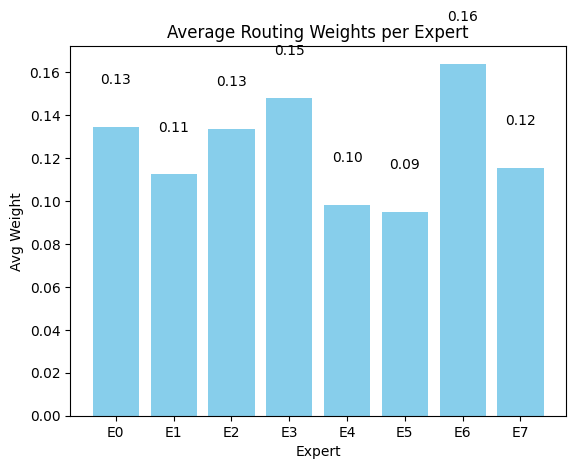

In [52]:
test_swiglu_and_moe()